# Amazon Electronic MLN Recommendation via PyTorch

adapted from https://github.com/fastai/fastai

In [87]:
import math
import copy
import os
import pickle
from pathlib import Path
from itertools import zip_longest

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import torch
from torch import nn
from torch import optim

figure_path = '/home/weiss/git/thesis/doc/figures/'

In [88]:
def set_random_seed(state=1):
    gens = (np.random.seed, torch.manual_seed, torch.cuda.manual_seed)
    for set_state in gens:
        set_state(state)

RANDOM_STATE = 2021
set_random_seed(RANDOM_STATE)

DIR = '/home/weiss/rs_data/amazon-electronic-product-recommendation/'

In [89]:
# pick one of the available folders
ratings = pd.read_pickle(DIR+'amazon-electronic-ratings.pkl')

In [90]:
ratings.head()

,user_id,item_id,rating
222,A3MV1KKHX51FYT,0380709473,4.0
306,A2I2KPNJDQ9SL0,0511189877,5.0
380,A2DFM26VLNVYNY,0511189877,5.0
649,A34GB2ZA1JLGND,0594033926,5.0
743,AT09WGFUM934H,0594481902,3.0


In [91]:
print(ratings['rating'].unique())

[4. 5. 3. 2. 1.]


In [92]:
def create_dataset(ratings, top=None):
    unique_users = ratings.user_id.unique()
    user_to_index = {old: new for new, old in enumerate(unique_users)}
    new_users = ratings.user_id.map(user_to_index)

    unique_items = ratings.item_id.unique()
    item_to_index = {old: new for new, old in enumerate(unique_items)}
    new_items = ratings.item_id.map(item_to_index)

    n_users = unique_users.shape[0]
    n_items = unique_items.shape[0]

    X = pd.DataFrame({'user_id': new_users, 'item_id': new_items})
    y = ratings['rating'].astype(np.int)
    return (n_users, n_items), (X, y), (user_to_index, item_to_index)

(n, m), (X, y), _ = create_dataset(ratings)
print(f'Embeddings: {n} users, {m} items')
print(f'Dataset shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(X.head())
print(y.head())

Embeddings: 5143 users, 115961 items
Dataset shape: (394059, 2)
Target shape: (394059,)
     user_id  item_id
222        0        0
306        1        1
380        2        1
649        3        2
743        4        3
222    4
306    5
380    5
649    5
743    3
Name: rating, dtype: int64


In [93]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4, random_state=RANDOM_STATE)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=RANDOM_STATE)
datasets = {'train': (X_train, y_train), 'val': (X_valid, y_valid), 'test': (X_test, y_test)}
dataset_sizes = {'train': len(X_train), 'val': len(X_valid), 'test': len(X_test)}

In [94]:
class RatingsIterator:

    def __init__(self, X, y, batch_size=32, shuffle=True):
        X, y = np.asarray(X), np.asarray(y)
        if shuffle:
            index = np.random.permutation(X.shape[0])
            X, y = X[index], y[index]
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_batches = int(math.ceil(X.shape[0] // batch_size))
        self._current = 0

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def next(self):
        if self._current >= self.n_batches:
            raise StopIteration()
        k = self._current
        self._current += 1
        bs = self.batch_size
        return self.X[k*bs:(k + 1)*bs], self.y[k*bs:(k + 1)*bs]

In [95]:
def batches(X, y, bs=32, shuffle=True):
    for xb, yb in RatingsIterator(X, y, bs, shuffle):
        xb = torch.LongTensor(xb)
        yb = torch.FloatTensor(yb)
        yield xb, yb.view(-1, 1)

In [96]:
class RecommenderNet(nn.Module):
    """
    Creates dense MLN with embedding layers.

    Args:
        n_users:
            Number of unique users in the dataset.

        n_items:
            Number of unique items in the dataset.

        n_factors:
            Number of columns in the embeddings matrix.

        embedding_dropout:
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of
            units in hidden layer(s).

        dropouts:
            A single integer or a list of integers defining the dropout
            layers rates applied right after each of hidden layers.

    """
    def __init__(self, n_users, n_items,
                 n_factors=50, embedding_dropout=0.3,
                 hidden=10, dropouts=0.3):

        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]

        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and
            their activations/dropouts.

            Note that the function captures `hidden` and `dropouts`
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)

            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield self.activation
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out

        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_items, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.activation = nn.Sigmoid()
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()

    def forward(self, users, items, minmax=None):
        features = torch.cat([self.u(users), self.m(items)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = self.activation(self.fc(x))
        #out = self.relu(self.fc(x))  # relu delivers worse rmse
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        return out

    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """

        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)

        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)


def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number or a list of numbers')

In [97]:
minmax = float(ratings.rating.min()), float(ratings.rating.max())
minmax

(1.0, 5.0)

In [98]:
#small

net = RecommenderNet(
    n_users=n, n_items=m,
    n_factors=20, hidden=[10, 10],
    embedding_dropout=0.1, dropouts=[0.1, 0.1])

In [99]:
lr = 1e-3
wd = 1e-6
bs = 4096
n_epochs = 300
patience = 300
no_improvements = 0
best_loss = np.inf
best_weights = None
history = []
lr_history = []

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net.to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
iterations_per_epoch = int(math.ceil(dataset_sizes['train'] // bs))

In [100]:
for epoch in range(n_epochs):
    stats = {'epoch': epoch + 1, 'total': n_epochs}

    for phase in ('train', 'val'):
        if phase == 'train':
          training = True
        else:
          training = False
        running_loss = 0
        n_batches = 0
        for batch in batches(*datasets[phase], shuffle=training, bs=bs):
            x_batch, y_batch = [b.to(device) for b in batch]
            optimizer.zero_grad()
            # compute gradients only during 'train' phase
            with torch.set_grad_enabled(training):
                outputs = net(x_batch[:,0], x_batch[:,1], minmax)
                loss = criterion(outputs, y_batch)
                # don't update weights and rates when in 'val' phase
                if training:
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / dataset_sizes[phase]
        stats[phase] = epoch_loss
        # early stopping: save weights of the best model so far
        if phase == 'val':
            if epoch_loss < best_loss:
                print('loss improvement on epoch: %d' % (epoch + 1))
                best_loss = epoch_loss
                best_weights = copy.deepcopy(net.state_dict())
                no_improvements = 0
            else:
                no_improvements += 1
    history.append(stats)
    print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
    if no_improvements >= patience:
        print('early stopping after epoch {epoch:03d}'.format(**stats))
        break

loss improvement on epoch: 1
[001/300] train: 1.2662 - val: 1.1756
loss improvement on epoch: 2
[002/300] train: 1.1740 - val: 1.1586
loss improvement on epoch: 3
[003/300] train: 1.1426 - val: 1.1306
loss improvement on epoch: 4
[004/300] train: 1.0850 - val: 1.0776
loss improvement on epoch: 5
[005/300] train: 0.9907 - val: 1.0272
loss improvement on epoch: 6
[006/300] train: 0.8877 - val: 1.0098
[007/300] train: 0.8012 - val: 1.0232
[008/300] train: 0.7338 - val: 1.0486
[009/300] train: 0.6840 - val: 1.0752
[010/300] train: 0.6512 - val: 1.0944
[011/300] train: 0.6242 - val: 1.1128
[012/300] train: 0.6065 - val: 1.1241
[013/300] train: 0.5917 - val: 1.1342
[014/300] train: 0.5803 - val: 1.1400
[015/300] train: 0.5708 - val: 1.1421
[016/300] train: 0.5613 - val: 1.1479
[017/300] train: 0.5550 - val: 1.1607
[018/300] train: 0.5471 - val: 1.1612
[019/300] train: 0.5420 - val: 1.1717
[020/300] train: 0.5370 - val: 1.1735
[021/300] train: 0.5321 - val: 1.1799
[022/300] train: 0.5286 - va

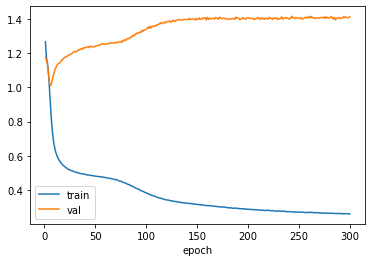

In [101]:
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
ax = pd.DataFrame(history).drop(columns='total').plot(x='epoch')

plt.savefig(figure_path + '/ammazon-small-loss.png', dpi=300, bbox_inches='tight')

In [102]:
net.load_state_dict(best_weights)

<All keys matched successfully>

In [103]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['val'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [104]:
valid_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Validation RMSE: {valid_loss:.4f}')

Validation RMSE: 1.0114


In [105]:
groud_truth, predictions = [], []

with torch.no_grad():
    for batch in batches(*datasets['test'], shuffle=False, bs=bs):
        x_batch, y_batch = [b.to(device) for b in batch]
        outputs = net(x_batch[:, 0], x_batch[:, 1], minmax)
        groud_truth.extend(y_batch.tolist())
        predictions.extend(outputs.tolist())

groud_truth = np.asarray(groud_truth).ravel()
predictions = np.asarray(predictions).ravel()

In [106]:
final_loss = np.sqrt(np.mean((predictions - groud_truth)**2))
print(f'Final RMSE: {final_loss:.4f}')

Final RMSE: 1.0174


In [107]:
with open('best.weights', 'wb') as file:
    pickle.dump(best_weights, file)